# Clustering Analysis

In this analysis we are looking at spatial variation of clusters relating to health and deprivation-related variables. Health is represented by number of deaths by preventable causes, found on on [Public Health England](https://fingertips.phe.org.uk/search/mortality). All data used in this analysis can be found on the relevant [Github Repo](https://github.com/signesw/Seeya_later).

This iteration of the analysis has greater disaggregation of ethnicity categories from 2011 Census and has removed 'population over 85' as it's accounted for in 'population over 65'.

## Import Packages

In [1]:
#Importing packages

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

In [2]:
#Importing machine learning packages and formatting

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [3]:
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Loading MSOA shapefile

<AxesSubplot:>

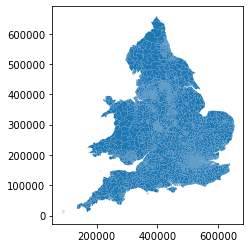

In [4]:
#loading the MSOAs for England and Wales

msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
msoas.plot()

In [5]:
msoas.sample(3)

OBJECTID   MSOA11CD        MSOA11NM       MSOA11NMW   BNG_E   BNG_N  \
4512      4513  E02004616    Cotswold 002    Cotswold 002  419772  228556   
4660      4661  E02004768      Havant 007      Havant 007  468765  108410   
1038      1039  E02001074  Manchester 030  Manchester 030  383854  394300   

      LONG   LAT     Shape__Are  Shape__Len  \
4512 -1.71 51.96 106,158,692.62   76,239.60   
4660 -1.02 50.87   1,489,727.28    6,299.57   
1038 -2.24 53.45   1,933,712.23    7,950.69   

                                               geometry  
4512  POLYGON ((425815.906 237703.891, 425875.781 23...  
4660  POLYGON ((469134.341 109156.507, 469443.952 10...  
1038  POLYGON ((385403.077 394868.355, 385168.713 39...

In [6]:
msoas.shape


(7201, 11)

In [7]:
msoas_england = msoas[msoas.MSOA11CD.str.startswith('E')]

In [8]:
msoas_england.head()

OBJECTID   MSOA11CD                  MSOA11NM                 MSOA11NMW  \
0         1  E02000001        City of London 001        City of London 001   
1         2  E02000002  Barking and Dagenham 001  Barking and Dagenham 001   
2         3  E02000003  Barking and Dagenham 002  Barking and Dagenham 002   
3         4  E02000004  Barking and Dagenham 003  Barking and Dagenham 003   
4         5  E02000005  Barking and Dagenham 004  Barking and Dagenham 004   

    BNG_E   BNG_N  LONG   LAT   Shape__Are  Shape__Len  \
0  532384  181355 -0.09 51.52 2,906,360.96    8,936.82   
1  548267  189685  0.14 51.59 2,166,163.21    8,150.41   
2  548259  188520  0.14 51.58 2,143,567.81    9,118.20   
3  551004  186412  0.18 51.56 2,491,466.74    8,206.55   
4  548733  186824  0.14 51.56 1,186,053.13    6,949.69   

                                            geometry  
0  POLYGON ((532135.138 182198.131, 532158.250 18...  
1  POLYGON ((548881.563 190845.265, 548881.125 19...  
2  POLYGON ((549102.438 189324.625, 548954.517 18...  
3  POLYGON ((551550.056 187364.705, 551478.000 18...  
4  POLYGON ((549099.634 187656.076, 549161.375 18...

In [9]:
msoas_england.shape

(6791, 11)

In [10]:
to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len']
msoas_england.drop(columns=to_drop, inplace = True)
print(msoas_england.shape)

(6791, 6)


/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
msoas_england.head()

OBJECTID   MSOA11CD                  MSOA11NM   BNG_E   BNG_N  \
0         1  E02000001        City of London 001  532384  181355   
1         2  E02000002  Barking and Dagenham 001  548267  189685   
2         3  E02000003  Barking and Dagenham 002  548259  188520   
3         4  E02000004  Barking and Dagenham 003  551004  186412   
4         5  E02000005  Barking and Dagenham 004  548733  186824   

                                            geometry  
0  POLYGON ((532135.138 182198.131, 532158.250 18...  
1  POLYGON ((548881.563 190845.265, 548881.125 19...  
2  POLYGON ((549102.438 189324.625, 548954.517 18...  
3  POLYGON ((551550.056 187364.705, 551478.000 18...  
4  POLYGON ((549099.634 187656.076, 549161.375 18...

In [12]:
msoas_england['borough'] = msoas_england.MSOA11NM.str.replace(r' \d+','',regex=True)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [13]:
#### Add MSOA Names using a Merge

#The House of Commons Library provides a [MSOA Names](https://visual.parliament.uk/msoanames) data set that contains locally-relevant names applied to MSOAs. 
#These seek to connect the Census geography (OA > LSOA > MSOA > LA) to a loosely-defined 'neighbourhood'.

In [14]:
msoa_nms = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/MSOA-Names-1.8.csv.gz?raw=true', compression='gzip')

In [15]:
print(msoa_nms.columns.values)
msoa_nms.sample(3, random_state=42)

['msoa11cd' 'msoa11nm' 'msoa11nmw' 'msoa11hclnm' 'msoa11hclnmw' 'Laname']


msoa11cd        msoa11nm      msoa11nmw              msoa11hclnm  \
4512  E02005951      Oxford 012     Oxford 012  Grandpont & New Hinksey   
4660  W02000113       Powys 017      Powys 017                   Brecon   
1038  W02000309  Caerphilly 020  Caerffili 020       Bedwas & Trethomas   

            msoa11hclnmw      Laname  
4512                 NaN      Oxford  
4660          Aberhonddu       Powys  
1038  Bedwas a Thretomas  Caerphilly

In [16]:
msoas = pd.merge(msoas_england, msoa_nms, how = 'inner' , left_on = 'MSOA11CD', right_on = 'msoa11cd')
print(msoas.shape)
print(type(msoas)) # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]

(6791, 13)
<class 'geopandas.geodataframe.GeoDataFrame'>


OBJECTID   MSOA11CD     MSOA11NM               msoa11hclnm
3142      3143  E02003230  Swindon 019  Central South & Eastcott
3076      3077  E02003161   Torbay 008           Torquay Central
101        102  E02000104    Brent 012             Wembley North

In [17]:
msoas.columns

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'BNG_E', 'BNG_N', 'geometry',
       'borough', 'msoa11cd', 'msoa11nm', 'msoa11nmw', 'msoa11hclnm',
       'msoa11hclnmw', 'Laname'],
      dtype='object')

In [18]:
# tidy up
to_drop = ['msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)
print(msoas.shape)

(6791, 8)


In [19]:
msoas.columns

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'BNG_E', 'BNG_N', 'geometry',
       'borough', 'msoa11hclnm'],
      dtype='object')

In [20]:
# SAVE

msoas.to_file(os.path.join('data','England_MSOAs.gpkg'), driver='GPKG')

## Importing all data

### Health data


In [21]:
# Set download URL
url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/preventable_deaths_phe.csv'
deaths = pd.read_csv(url, low_memory=False)
print(f"Data frame is {deaths.shape[0]:,} x {deaths.shape[1]}")

Data frame is 6,791 x 5


In [22]:
deaths.head()

Code                     Label  \
0  E02000001        City of London 001   
1  E02000002  Barking and Dagenham 001   
2  E02000003  Barking and Dagenham 002   
3  E02000004  Barking and Dagenham 003   
4  E02000005  Barking and Dagenham 004   

   Deaths from causes considered preventable\nlower confidence limit  \
0                                              49.90                   
1                                              68.30                   
2                                              79.80                   
3                                              83.40                   
4                                              79.10                   

   Deaths from causes considered preventable  \
0                                      68.50   
1                                      93.60   
2                                     101.80   
3                                     110.70   
4                                     103.90   

   Deaths from causes considered preventable\nupper confidence limit  
0                                              91.60                  
1                                             125.20                  
2                                             128.00                  
3                                             144.00                  
4                                             134.00

In [23]:
deaths = deaths[['Code', 'Label', 'Deaths from causes considered preventable']]

In [24]:
deaths.head()

Code                     Label  \
0  E02000001        City of London 001   
1  E02000002  Barking and Dagenham 001   
2  E02000003  Barking and Dagenham 002   
3  E02000004  Barking and Dagenham 003   
4  E02000005  Barking and Dagenham 004   

   Deaths from causes considered preventable  
0                                      68.50  
1                                      93.60  
2                                     101.80  
3                                     110.70  
4                                     103.90

In [25]:
deaths.shape

(6791, 3)

### Demographic data

In [26]:
## Reading in household poverty after housing costs
## IMD 2019 available at LSOA but was downloaded from https://research.mysociety.org/sites/imd2019/about/ at MSOA level
#the IMD decile was aggregated and averaged across the LSOAs that fall into the MSOAs

In [27]:
# Set download URL
url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/IMD2019-demographs-MSOA.csv'
socio_demo = pd.read_csv(url, low_memory=False)
socio_demo.head()

MSOAC            MSOAHOCLN     LAD19C                LAD19N     REG  \
0  E02000001       City of London  E09000001        City of London  London   
1  E02000002           Marks Gate  E09000002  Barking and Dagenham  London   
2  E02000003  Chadwell Heath East  E09000002  Barking and Dagenham  London   
3  E02000004         Eastbrookend  E09000002  Barking and Dagenham  London   
4  E02000005      Becontree Heath  E09000002  Barking and Dagenham  London   

   LSOACOUNT  POPMID15  IMD19 SCORE  MSOARANK  MSOADECILE  MSOAQUINTILE  \
0       6.00  6,687.00        14.72  4,198.00        7.00          4.00   
1       4.00  7,379.00        34.77  1,060.00        2.00          1.00   
2       6.00 10,720.00        25.15  2,200.00        4.00          2.00   
3       4.00  6,536.00        23.56  2,429.00        4.00          2.00   
4       5.00  9,243.00        30.21  1,519.00        3.00          2.00   

   Percentage of Households Below 60% of the Median Income; (after housing costs)  \
0                                              15.50                                
1                                              28.10                                
2                                              21.60                                
3                                              22.20                                
4                                              23.10                                

   Percentage of Households Below 60% of the Median Income; (after housing costs); 95% Confidence Interval Lower Limit  \
0                                               8.10                                                                     
1                                              21.30                                                                     
2                                              16.00                                                                     
3                                              16.40                                                                     
4                                              17.00                                                                     

   Percentage of Households Below 60% of the Median Income; (after housing costs); 95% Confidence Interval Upper Limit  
0                                              27.40                                                                    
1                                              35.80                                                                    
2                                              28.30                                                                    
3                                              29.20                                                                    
4                                              30.50

In [28]:
url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/community_data.csv'
pop_and_demo = pd.read_csv(url, low_memory=False)
pop_and_demo.rename(columns={'Code':'MSOAC'}, inplace=True)
pop_and_demo.head()

MSOAC                     Label  \
0  E02000001        City of London 001   
1  E02000002  Barking and Dagenham 001   
2  E02000003  Barking and Dagenham 002   
3  E02000004  Barking and Dagenham 003   
4  E02000005  Barking and Dagenham 004   

   Black and Minority Ethnic Population\nlower confidence limit  \
0                                              20.40              
1                                              33.90              
2                                              44.40              
3                                              18.10              
4                                              32.70              

   Black and Minority Ethnic Population  \
0                                 21.40   
1                                 35.00   
2                                 45.40   
3                                 19.00   
4                                 33.70   

   Black and Minority Ethnic Population\nupper confidence limit  \
0                                              22.30              
1                                              36.20              
2                                              46.40              
3                                              20.00              
4                                              34.70              

   Long Term Unemployment\nlower confidence limit  Long Term Unemployment  \
0                                            1.80                    3.00   
1                                            5.20                    7.30   
2                                            2.50                    3.70   
3                                            5.70                    7.90   
4                                            3.00                    4.40   

   Long Term Unemployment\nupper confidence limit  \
0                                            4.90   
1                                           10.20   
2                                            5.40   
3                                           11.10   
4                                            6.30   

   Index of Multiple Deprivation (IMD) Score 2015  \
0                                           13.60   
1                                           38.50   
2                                           25.70   
3                                           24.80   
4                                           32.50   

   Proportion of households in poverty\nlower confidence limit  ...  \
0                                               8.10            ...   
1                                              21.30            ...   
2                                              16.00            ...   
3                                              16.40            ...   
4                                              17.00            ...   

   Population aged 16 to 24 years\nupper confidence limit  \
0                                               9.70        
1                                              11.30        
2                                              10.80        
3                                              14.20        
4                                              11.80        

   Population aged 25 to 64 years\nlower confidence limit  \
0                                              55.50        
1                                              47.20        
2                                              53.10        
3                                              49.20        
4                                              51.20        

   Population aged 25 to 64 years  \
0                           56.60   
1                           48.30   
2                           54.10   
3                           50.40   
4                           52.20   

   Population aged 25 to 64 years\nupper confidence limit  \
0                                              57.70        
1                                              49.40        
2                    

In [29]:
url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/Ethnicities.csv'
ethnicities = pd.read_csv(url,low_memory=False)
ethnicities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   MSOA Code                         6791 non-null   object
 1   MSOA Name                         6791 non-null   object
 2   All                               6791 non-null   int64 
 3   White                             6791 non-null   int64 
 4   Asian/Asian British: Indian       6791 non-null   int64 
 5   Asian/Asian British: Pakistani    6791 non-null   int64 
 6   Asian/Asian British: Bangladeshi  6791 non-null   int64 
 7   Asian/Asian British: Chinese      6791 non-null   int64 
 8   Black                             6791 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 477.6+ KB


In [30]:
#reading in more detailed ethnicities data

url = 'https://raw.githubusercontent.com/signesw/Seeya_later/main/data/Ethnicities.csv'
ethnicities = pd.read_csv(url,low_memory=False)
#calculating percentages of total population per MSOA of each ethnicity
ethnicities[['White', 'Asian/Asian British: Indian',
             'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi',
             'Asian/Asian British: Chinese', 'Black']] = ethnicities[['White', 'Asian/Asian British: Indian',
             'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi',
             'Asian/Asian British: Chinese', 'Black']].divide(ethnicities['All'], axis='index')
#create 'other' column
ethnicities['Other'] = ethnicities[['White', 'Asian/Asian British: Indian',
             'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi',
             'Asian/Asian British: Chinese', 'Black']].sum(axis=1)

ethnicities['Other'] = 1 - ethnicities['Other']

#creating combined categories of ethnicities 
ethnicities['Chinese_Other'] = ethnicities[['Asian/Asian British: Chinese','Other']].sum(axis=1)
ethnicities['Subcont'] = ethnicities[['Asian/Asian British: Indian', 'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi']].sum(axis=1)

ethnicities.drop(['Asian/Asian British: Indian',
             'Asian/Asian British: Pakistani', 'Asian/Asian British: Bangladeshi',
             'Asian/Asian British: Chinese', 'Other'], axis=1, inplace = True)

ethnicities.head()

MSOA Code       MSOA Name   All  White  Black  Chinese_Other  Subcont
0  E02002559  Darlington 001  8842   0.97   0.00           0.02     0.01
1  E02002560  Darlington 002  5997   0.98   0.00           0.01     0.01
2  E02002561  Darlington 003  5741   0.98   0.00           0.02     0.01
3  E02002562  Darlington 004  6066   0.96   0.00           0.02     0.01
4  E02002563  Darlington 005  5463   0.98   0.00           0.02     0.00

In [31]:
#merge dataframes
pop_and_demo = pd.merge(socio_demo, pop_and_demo, on = 'MSOAC')
pop_and_demo = pd.merge(ethnicities, pop_and_demo, left_on = 'MSOA Code', right_on = 'MSOAC')
pop_and_demo.head()

MSOA Code       MSOA Name   All  White  Black  Chinese_Other  Subcont  \
0  E02002559  Darlington 001  8842   0.97   0.00           0.02     0.01   
1  E02002560  Darlington 002  5997   0.98   0.00           0.01     0.01   
2  E02002561  Darlington 003  5741   0.98   0.00           0.02     0.01   
3  E02002562  Darlington 004  6066   0.96   0.00           0.02     0.01   
4  E02002563  Darlington 005  5463   0.98   0.00           0.02     0.00   

       MSOAC                          MSOAHOCLN     LAD19C  ...  \
0  E02002559  Faverdale, Heighington & Sadberge  E06000005  ...   
1  E02002560                    Harrowgate Hill  E06000005  ...   
2  E02002561                          Whinfield  E06000005  ...   
3  E02002562                          Rise Carr  E06000005  ...   
4  E02002563                 Haughton Le Skerne  E06000005  ...   

  Population aged 16 to 24 years\nupper confidence limit  \
0                                               8.20       
1                                               9.60       
2                                               8.70       
3                                              11.40       
4                                              10.00       

  Population aged 25 to 64 years\nlower confidence limit  \
0                                              52.20       
1                                              51.20       
2                                              51.20       
3                                              52.40       
4                                              47.60       

   Population aged 25 to 64 years  \
0                           53.20   
1                           52.40   
2                           52.60   
3                           53.70   
4                           48.90   

   Population aged 25 to 64 years\nupper confidence limit  \
0                                              54.30        
1                                              53.60        
2                                              53.90        
3                                              54.90        
4                                              50.30        

   Population aged 65 years and over\nlower confidence limit  \
0                                              18.60           
1                                              17.30           
2                                              22.50           
3                                              17.00           
4                                              24.30           

   Population aged 65 years and over  \
0                              19.40   
1                              18.30   
2                              23.60   
3                              18.00   
4                              25.40   

   Population aged 65 years and over\nupper confidence limit  \
0                                              20.30           
1                                              19.30           
2                                              24.70           
3                                              19.00           
4                                              26.60           

   Population aged 85 years and over\nlower confidence limit  \
0                                               1.40           
1                                               1.20           
2                                               2.10           
3                                               2.30           
4                                               4.40           

   Population aged 85 years and over  \
0                               1.60   
1                               1.40   
2                               2.50   
3                               2.70   
4                               5.00   

   Population aged 85 years and over\nupper confidence limit  
0                                               1.90          
1                                               1.80          
2    

In [32]:
pop_and_demo.columns

Index(['MSOA Code', 'MSOA Name', 'All', 'White', 'Black', 'Chinese_Other',
       'Subcont', 'MSOAC', 'MSOAHOCLN', 'LAD19C', 'LAD19N', 'REG', 'LSOACOUNT',
       'POPMID15', 'IMD19 SCORE', 'MSOARANK', 'MSOADECILE', 'MSOAQUINTILE',
       'Percentage of Households Below 60% of the Median Income; (after housing costs)',
       'Percentage of Households Below 60% of the Median Income; (after housing costs); 95% Confidence Interval Lower Limit',
       'Percentage of Households Below 60% of the Median Income; (after housing costs); 95% Confidence Interval Upper Limit',
       'Label', 'Black and Minority Ethnic Population\nlower confidence limit',
       'Black and Minority Ethnic Population',
       'Black and Minority Ethnic Population\nupper confidence limit',
       'Long Term Unemployment\nlower confidence limit',
       'Long Term Unemployment',
       'Long Term Unemployment\nupper confidence limit',
       'Index of Multiple Deprivation (IMD) Score 2015',
       'Proportion of hous

In [33]:
to_keep = ['MSOAC', 'Label', 'White', 'Black', 'Chinese_Other',
           'Subcont','Long Term Unemployment','IMD19 SCORE', 
           'Percentage of Households Below 60% of the Median Income; (after housing costs)',
           'Proportion of households in poverty',
           'Population 0 to 15 years','Population aged 16 to 24 years', 
           'Population aged 25 to 64 years', 'Population aged 65 years and over', 
           'Population aged 85 years and over']

pop_and_demo = pop_and_demo[to_keep]
pop_and_demo.head()

MSOAC           Label  White  Black  Chinese_Other  Subcont  \
0  E02002559  Darlington 001   0.97   0.00           0.02     0.01   
1  E02002560  Darlington 002   0.98   0.00           0.01     0.01   
2  E02002561  Darlington 003   0.98   0.00           0.02     0.01   
3  E02002562  Darlington 004   0.96   0.00           0.02     0.01   
4  E02002563  Darlington 005   0.98   0.00           0.02     0.00   

   Long Term Unemployment  IMD19 SCORE  \
0                    0.90        13.22   
1                    4.20        15.88   
2                    4.20        17.18   
3                   15.40        41.12   
4                    6.10        28.71   

   Percentage of Households Below 60% of the Median Income; (after housing costs)  \
0                                              13.00                                
1                                              13.00                                
2                                              16.00                                
3                                              32.70                                
4                                              20.30                                

   Proportion of households in poverty  Population 0 to 15 years  \
0                                13.00                     19.70   
1                                13.00                     20.50   
2                                16.00                     15.90   
3                                32.70                     17.70   
4                                20.30                     16.50   

   Population aged 16 to 24 years  Population aged 25 to 64 years  \
0                            7.60                           53.20   
1                            8.90                           52.40   
2                            8.00                           52.60   
3                           10.60                           53.70   
4                            9.20                           48.90   

   Population aged 65 years and over  Population aged 85 years and over  
0                              19.40                               1.60  
1                              18.30                               1.40  
2                              23.60                               2.50  
3                              18.00                               2.70  
4                              25.40                               5.00

In [34]:
#Rename MSOAC to Code and merge deaths data to demographic data

pop_and_demo.rename(columns={'MSOAC':'Code','Label_x':'Label'}, inplace=True)
variables = pd.merge(deaths, pop_and_demo, on = 'Code')
variables.drop(['Label_y','Percentage of Households Below 60% of the Median Income; (after housing costs)'], axis = 1, inplace = True)
variables.rename(columns={'Label_x':'Label'}, inplace = True)
variables.columns

Index(['Code', 'Label', 'Deaths from causes considered preventable', 'White',
       'Black', 'Chinese_Other', 'Subcont', 'Long Term Unemployment',
       'IMD19 SCORE', 'Proportion of households in poverty',
       'Population 0 to 15 years', 'Population aged 16 to 24 years',
       'Population aged 25 to 64 years', 'Population aged 65 years and over',
       'Population aged 85 years and over'],
      dtype='object')

## Initial Clustering and Mapping

In [35]:
#creating gdf

gdf = pd.merge(msoas, variables, left_on = 'MSOA11CD', right_on = 'Code', how = 'inner')

gdf = gdf.drop(columns=['MSOA11CD','White']).rename(columns={'Code': 'MSOA_code', 
                                                                'Deaths from causes considered preventable' : 'preventable_deaths',
                                                                'IMD19 Score':'IMD19',
                                                                'Long Term Unemployment' : 'longterm_unemployed', 
                                                                'Proportion of households in poverty' : 'household_poverty',
                                                                'Population 0 to 15 years' : 'pop_0_15', 
                                                                'Population aged 16 to 24 years' : 'pop_16_24', 
                                                                'Population aged 25 to 64 years' : 'pop_25_64', 
                                                                'Population aged 65 years and over' : 'pop_above_65', 
                                                                'Population aged 85 years and over' : 'pop_above_85' })

print(f"England MSOA preventable deaths and demographics data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")
gdf.head()

England MSOA preventable deaths and demographics data frame has shape 6,791 x 21


OBJECTID                  MSOA11NM   BNG_E   BNG_N  \
0         1        City of London 001  532384  181355   
1         2  Barking and Dagenham 001  548267  189685   
2         3  Barking and Dagenham 002  548259  188520   
3         4  Barking and Dagenham 003  551004  186412   
4         5  Barking and Dagenham 004  548733  186824   

                                            geometry               borough  \
0  POLYGON ((532135.138 182198.131, 532158.250 18...        City of London   
1  POLYGON ((548881.563 190845.265, 548881.125 19...  Barking and Dagenham   
2  POLYGON ((549102.438 189324.625, 548954.517 18...  Barking and Dagenham   
3  POLYGON ((551550.056 187364.705, 551478.000 18...  Barking and Dagenham   
4  POLYGON ((549099.634 187656.076, 549161.375 18...  Barking and Dagenham   

           msoa11hclnm  MSOA_code                     Label  \
0       City of London  E02000001        City of London 001   
1           Marks Gate  E02000002  Barking and Dagenham 001   
2  Chadwell Heath East  E02000003  Barking and Dagenham 002   
3         Eastbrookend  E02000004  Barking and Dagenham 003   
4      Becontree Heath  E02000005  Barking and Dagenham 004   

   preventable_deaths  ...  Chinese_Other  Subcont  longterm_unemployed  \
0               68.50  ...           0.12     0.06                 3.00   
1               93.60  ...           0.10     0.09                 7.30   
2              101.80  ...           0.11     0.19                 3.70   
3              110.70  ...           0.06     0.02                 7.90   
4              103.90  ...           0.07     0.09                 4.40   

   IMD19 SCORE  household_poverty  pop_0_15  pop_16_24  pop_25_64  \
0        14.72              15.50     15.10       9.00      56.60   
1        34.77              28.10     27.40      10.60      48.30   
2        25.15              21.60     23.50      10.20      54.10   
3        23.56              22.20     20.00      13.30      50.40   
4        30.21              23.10     27.00      11.20      52.20   

   pop_above_65  pop_above_85  
0         19.40          2.60  
1         13.70          3.00  
2         12.20          1.90  
3         16.30          3.40  
4          9.60          1.40  

[5 rows x 21 columns]

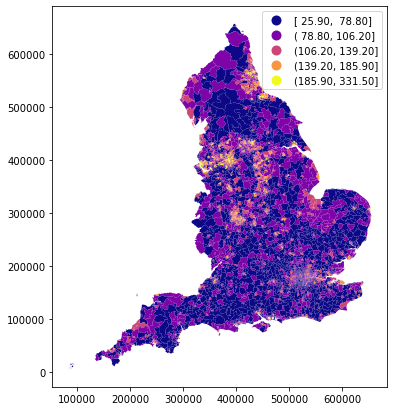

In [36]:
#Quick initial map
import mapclassify.classifiers as classifiers

gdf.plot(column='preventable_deaths', cmap='plasma', 
         scheme='FisherJenks', edgecolor='None', legend=True, figsize=(9,7));

In [37]:
gdf.columns

Index(['OBJECTID', 'MSOA11NM', 'BNG_E', 'BNG_N', 'geometry', 'borough',
       'msoa11hclnm', 'MSOA_code', 'Label', 'preventable_deaths', 'Black',
       'Chinese_Other', 'Subcont', 'longterm_unemployed', 'IMD19 SCORE',
       'household_poverty', 'pop_0_15', 'pop_16_24', 'pop_25_64',
       'pop_above_65', 'pop_above_85'],
      dtype='object')

In [38]:
gdf_vars = gdf[['preventable_deaths',
       'Black', 'Chinese_Other', 'Subcont', 'longterm_unemployed',
       'IMD19 SCORE', 'household_poverty', 'pop_0_15', 'pop_16_24',
       'pop_25_64', 'pop_above_65']] 

Text(0.5, 1.0, 'Correlation Matrix')

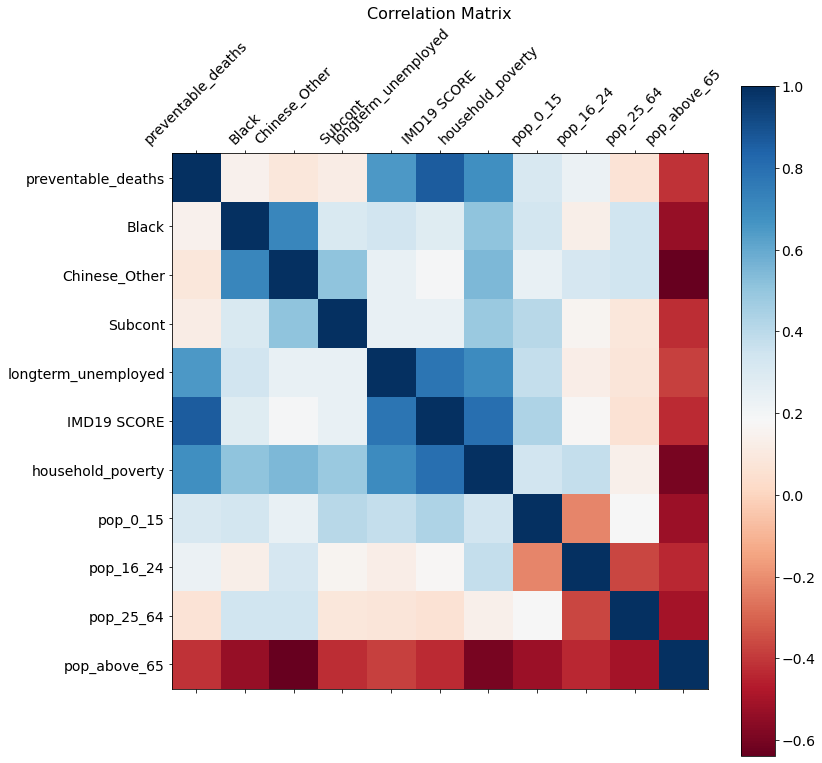

In [39]:
#plotting correlation matrix and checking for multicollinearity
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 12))
plt.matshow(gdf_vars.corr(), fignum=f.number, cmap= 'RdBu')
#cmap = cm.jet
#cmaps['Perceptually Uniform Sequential'] = [ 'viridis', 'plasma', 'inferno', 'magma', 'cividis']

plt.xticks(range(gdf_vars.shape[1]), gdf_vars.columns, fontsize=14, rotation=45)
plt.yticks(range(gdf_vars.shape[1]), gdf_vars.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
#plt.savefig('correlation_matrix.png', bbox_inches='tight')
#plt.matshow(corr, cmap=cm.jet)

<AxesSubplot:>

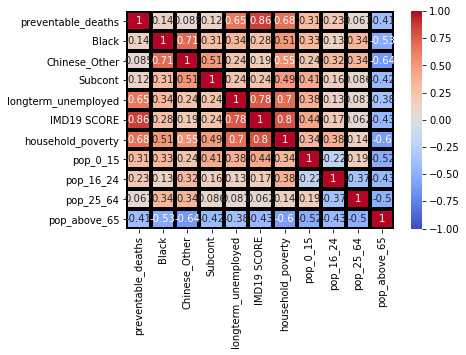

In [40]:
# trying this again with seaborn
# will make look nicer later
# code from this link:
#https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07


sns.heatmap(gdf_vars.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')


#### 28/04/21
Dropping IMD2019 to see what the clusters look like
Reasonsing: highly correlated with both preventable deaths (0.86), longtern unemployment (0.78) and household poverty (0.8);
also, theoretically, the IMD takes factors such as poverty and poor health into account (although maybe not via the same explicit variables). So this might explain the high correlation

In [41]:
gdf_vars = gdf_vars[['preventable_deaths',
       'Black', 'Chinese_Other', 'Subcont', 'longterm_unemployed', 'household_poverty', 'pop_0_15', 'pop_16_24',
       'pop_25_64', 'pop_above_65']]

In [42]:
gdf_vars['MSOA11CD'] = gdf[['MSOA_code']]
gdf_vars = gdf_vars.fillna(0).set_index('MSOA11CD')
gdf_vars.head()

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001               68.50   0.03           0.12     0.06   
E02000002               93.60   0.17           0.10     0.09   
E02000003              101.80   0.16           0.11     0.19   
E02000004              110.70   0.10           0.06     0.02   
E02000005              103.90   0.17           0.07     0.09   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                 3.00              15.50     15.10       9.00   
E02000002                 7.30              28.10     27.40      10.60   
E02000003                 3.70              21.60     23.50      10.20   
E02000004                 7.90              22.20     20.00      13.30   
E02000005                 4.40              23.10     27.00      11.20   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001      56.60         19.40  
E02000002      48.30         13.70  
E02000003      54.10         12.20  
E02000004      50.40         16.30  
E02000005      52.20          9.60

### Standardising the Data

In [43]:
# make a copy of the df for each transformation

In [44]:
sts = StandardScaler()
rbs = RobustScaler(quantile_range=[25,25])
mms = MinMaxScaler(feature_range=(-1,1))
rbs2 = RobustScaler(quantile_range=[10,90])


In [45]:
gdf_vars1 = gdf_vars.copy()
for c in gdf_vars1.columns.values:
    gdf_vars1[c] = sts.fit_transform(gdf_vars1[c].values.reshape(-1,1))
gdf_vars1.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001               -0.91  -0.10           1.31     0.11   
E02000002               -0.26   2.13           0.77     0.35   
E02000003               -0.04   2.03           1.00     1.30   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                -0.12              -0.66     -1.00      -0.28   
E02000002                 0.99               0.82      2.15       0.01   
E02000003                 0.06               0.06      1.15      -0.06   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001       1.00          0.12  
E02000002      -0.75         -0.72  
E02000003       0.47         -0.93

In [46]:
gdf_vars2 = gdf_vars.copy()

for c in gdf_vars2.columns.values:
    gdf_vars2[c] = rbs.fit_transform(gdf_vars2[c].values.reshape(-1,1))
gdf_vars2.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001              -26.10   0.02           0.10     0.05   
E02000002               -1.00   0.16           0.07     0.07   
E02000003                7.20   0.15           0.08     0.17   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                 0.90              -3.30     -3.60      -0.50   
E02000002                 5.20               9.30      8.70       1.10   
E02000003                 1.60               2.80      4.80       0.70   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001       5.00          0.80  
E02000002      -3.30         -4.90  
E02000003       2.50         -6.40

In [47]:
gdf_vars3 = gdf_vars.copy()

for c in gdf_vars3.columns.values:
    gdf_vars3[c] = mms.fit_transform(gdf_vars3[c].values.reshape(-1,1))
gdf_vars3.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001               -0.72  -0.90          -0.34    -0.84   
E02000002               -0.56  -0.39          -0.50    -0.78   
E02000003               -0.50  -0.41          -0.43    -0.54   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                -0.83              -0.69     -0.26      -0.88   
E02000002                -0.58              -0.25      0.41      -0.84   
E02000003                -0.79              -0.48      0.20      -0.85   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001       0.40         -0.27  
E02000002       0.14         -0.49  
E02000003       0.32         -0.55

In [48]:
gdf_vars4 = gdf_vars.copy()

for c in gdf_vars4.columns.values:
    gdf_vars4[c] = rbs2.fit_transform(gdf_vars4[c].values.reshape(-1,1))
gdf_vars4.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001               -0.28   0.20           0.76     0.39   
E02000002               -0.01   1.71           0.52     0.59   
E02000003                0.08   1.65           0.62     1.35   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                 0.12              -0.16     -0.39      -0.10   
E02000002                 0.68               0.44      0.94       0.22   
E02000003                 0.21               0.13      0.52       0.14   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001       0.51          0.05  
E02000002      -0.33         -0.28  
E02000003       0.25         -0.36

### Making the data more gaussian - Transformation

In [49]:
# https://machinelearningmastery.com/power-transforms-with-scikit-learn/

pts1 = PowerTransformer(method='yeo-johnson')
#pts2 = PowerTransformer(method='box-cox') #turns out we cannot use this method as the data must be 'strictly positive', and we have many 0 values
# np.log will also be used

In [50]:
gdf_vars11 = gdf_vars1.copy()
for c in gdf_vars11.columns.values:
    gdf_vars11[c] = pts1.fit_transform(gdf_vars11[c].values.reshape(-1,1))
gdf_vars11.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001               -1.05   0.69           1.45     1.14   
E02000002               -0.06   1.89           1.21     1.43   
E02000003                0.20   1.89           1.32     1.84   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                 0.31              -0.64     -1.01      -0.22   
E02000002                 1.31               1.00      2.03       0.56   
E02000003                 0.57               0.36      1.14       0.40   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001       1.00          0.17  
E02000002      -0.75         -0.70  
E02000003       0.47         -0.94

In [51]:
gdf_vars12 = gdf_vars1.copy()
for c in gdf_vars12.columns.values:
    gdf_vars12[c] = np.log(gdf_vars12[c].values.reshape(-1,1))
gdf_vars12.head(3)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001                 nan    nan           0.27    -2.18   
E02000002                 nan   0.76          -0.26    -1.04   
E02000003                 nan   0.71          -0.00     0.26   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                  nan                nan       nan        nan   
E02000002                -0.01              -0.20      0.76      -4.51   
E02000003                -2.77              -2.90      0.14        nan   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001      -0.00         -2.14  
E02000002        nan           nan  
E02000003      -0.75           nan

In [52]:
gdf_vars21 = gdf_vars2.copy()
for c in gdf_vars21.columns.values:
    gdf_vars21[c] = pts1.fit_transform(gdf_vars21[c].values.reshape(-1,1))
gdf_vars21.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001               -1.06   0.55           1.52     1.05   
E02000002                0.02   2.04           1.24     1.42   
E02000003                0.23   2.03           1.38     1.98   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                 0.35              -0.61     -1.02      -0.13   
E02000002                 1.20               0.93      2.02       0.52   
E02000003                 0.55               0.36      1.13       0.40   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001       1.00          0.16  
E02000002      -0.75         -0.70  
E02000003       0.48         -0.94

In [53]:
gdf_vars22 = gdf_vars2.copy()
for c in gdf_vars22.columns.values:
    gdf_vars22[c] = np.log(gdf_vars22[c].values.reshape(-1,1))
gdf_vars22.head(3)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001                 nan  -3.98          -2.35    -3.00   
E02000002                 nan  -1.83          -2.72    -2.60   
E02000003                1.97  -1.87          -2.55    -1.76   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                -0.11                nan       nan        nan   
E02000002                 1.65               2.23      2.16       0.10   
E02000003                 0.47               1.03      1.57      -0.36   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001       1.61         -0.22  
E02000002        nan           nan  
E02000003       0.92           nan

In [54]:
gdf_vars31 = gdf_vars3.copy()
for c in gdf_vars31.columns.values:
    gdf_vars31[c] = pts1.fit_transform(gdf_vars31[c].values.reshape(-1,1))
gdf_vars31.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001               -1.04   0.43           1.58     0.93   
E02000002               -0.11   2.18           1.25     1.35   
E02000003                0.15   2.17           1.40     2.12   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                 0.20              -0.67     -1.01      -0.29   
E02000002                 1.42               1.04      2.04       0.48   
E02000003                 0.47               0.30      1.14       0.31   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001       1.00          0.17  
E02000002      -0.76         -0.70  
E02000003       0.46         -0.94

In [55]:
gdf_vars32 = gdf_vars3.copy()
for c in gdf_vars32.columns.values:
    gdf_vars32[c] = np.log(gdf_vars32[c].values.reshape(-1,1))
gdf_vars32.head(3)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001                 nan    nan            nan      nan   
E02000002                 nan    nan            nan      nan   
E02000003                 nan    nan            nan      nan   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                  nan                nan       nan        nan   
E02000002                  nan                nan     -0.88        nan   
E02000003                  nan                nan     -1.61        nan   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001      -0.90           nan  
E02000002      -1.97           nan  
E02000003      -1.12           nan

In [56]:
gdf_vars41 = gdf_vars4.copy()
for c in gdf_vars41.columns.values:
    gdf_vars41[c] = pts1.fit_transform(gdf_vars41[c].values.reshape(-1,1))
gdf_vars41.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001               -1.04   0.70           1.47     1.12   
E02000002               -0.06   1.88           1.22     1.41   
E02000003                0.19   1.87           1.34     1.82   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                 0.30              -0.63     -1.01      -0.20   
E02000002                 1.32               1.01      2.04       0.54   
E02000003                 0.55               0.34      1.14       0.39   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001       1.00          0.17  
E02000002      -0.75         -0.70  
E02000003       0.47         -0.94

In [57]:
gdf_vars42 = gdf_vars4.copy()
for c in gdf_vars42.columns.values:
    gdf_vars42[c] = np.log(gdf_vars42[c].values.reshape(-1,1))
gdf_vars42.head(3)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001                 nan  -1.60          -0.28    -0.94   
E02000002                 nan   0.54          -0.65    -0.53   
E02000003               -2.55   0.50          -0.48     0.30   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                -2.13                nan       nan        nan   
E02000002                -0.38              -0.81     -0.07      -1.51   
E02000003                -1.56              -2.01     -0.66      -1.97   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001      -0.68         -3.10  
E02000002        nan           nan  
E02000003      -1.38           nan

In [58]:
#print(gdf_vars1.mean(axis=0))

In [59]:
print(gdf_vars.describe())

       preventable_deaths    Black  Chinese_Other  Subcont  \
count            6,791.00 6,791.00       6,791.00 6,791.00   
mean               103.53     0.03           0.05     0.05   
std                 38.61     0.06           0.05     0.10   
min                 25.90     0.00           0.00     0.00   
25%                 75.25     0.00           0.02     0.00   
50%                 94.60     0.01           0.03     0.01   
75%                123.80     0.03           0.07     0.04   
max                331.50     0.55           0.37     0.81   

       longterm_unemployed  household_poverty  pop_0_15  pop_16_24  pop_25_64  \
count             6,791.00           6,791.00  6,791.00   6,791.00   6,791.00   
mean                  3.46              21.13     19.01      10.54      51.85   
std                   3.90               8.55      3.90       5.57       4.76   
min                   0.00               6.70      1.60       4.50      12.70   
25%                   1.10          

### The 'standard scaler (z-score) + log transformation' seems to have made the most variables as gaussian as possible. We will proceed with this dataset.

#### See "ClusteringAnalysis_StandardisedAndTranformed" notebook for proof

In [60]:
# We also create a 'result set' (rs) data frame to hold the 
# results of the clustering operation
rs = pd.merge(msoas, gdf_vars12, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')

## First K-Means Clustering
#### Let's see what 6 clusters looks like

In [61]:
gdf_vars12.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001                 nan    nan           0.27    -2.18   
E02000002                 nan   0.76          -0.26    -1.04   
E02000003                 nan   0.71          -0.00     0.26   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                  nan                nan       nan        nan   
E02000002                -0.01              -0.20      0.76      -4.51   
E02000003                -2.77              -2.90      0.14        nan   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001      -0.00         -2.14  
E02000002        nan           nan  
E02000003      -0.75           nan

In [62]:
gdf_vars12 = gdf_vars12.fillna(0)
gdf_vars12.head(3)

preventable_deaths  Black  Chinese_Other  Subcont  \
MSOA11CD                                                       
E02000001                0.00   0.00           0.27    -2.18   
E02000002                0.00   0.76          -0.26    -1.04   
E02000003                0.00   0.71          -0.00     0.26   

           longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
MSOA11CD                                                                 
E02000001                 0.00               0.00      0.00       0.00   
E02000002                -0.01              -0.20      0.76      -4.51   
E02000003                -2.77              -2.90      0.14       0.00   

           pop_25_64  pop_above_65  
MSOA11CD                            
E02000001      -0.00         -2.14  
E02000002       0.00          0.00  
E02000003      -0.75          0.00

In [63]:
c_nm   = 'KMeans6' # Clustering name
k_pref = 6 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(gdf_vars12) # The process
print(kmeans.labels_) # The results

[5 4 0 ... 1 0 1]


Capture the cluster centers for our table:

In [64]:
centers = kmeans.cluster_centers_
print(centers)
print(type(centers))

[[-1.23735291e+00 -2.55645507e-01 -1.87173802e-01 -5.17369991e-02
  -1.10058348e+00 -1.04611185e+00 -3.02899425e-01 -8.57330386e-02
  -2.17187421e-01 -1.29147565e-01]
 [-1.11693103e-03 -5.20095145e-02 -6.35870349e-02  3.83442309e-02
  -1.65560187e-03  3.62053178e-02 -1.00792351e-01 -2.69531639e-02
  -5.27484607e-02 -4.08404256e-02]
 [-2.80406037e-01 -9.79657475e-02 -1.96737663e-01 -6.57878632e-02
  -1.66368402e-01 -2.04388552e-01 -1.62714160e+00 -9.39506994e-02
  -4.52748664e-01 -2.16723932e+00]
 [-1.58899809e-01 -9.55505739e-02 -1.16407332e-01 -2.54419736e-02
  -1.45159617e-01 -1.24601361e-01 -2.05926420e-01 -1.79077528e-01
  -2.45719480e+00 -6.30849890e-01]
 [-6.89700894e-02 -1.15601921e-01 -1.39011993e-01 -6.82519350e-03
  -1.63758294e-01 -1.87583669e-01 -2.22275770e-01 -2.73421051e+00
  -3.96735830e-01 -1.58303698e-01]
 [-1.83005952e-01 -3.93379712e-01 -2.19911549e-01 -2.73161069e+00
  -2.00588626e-01 -1.40790856e-01 -2.86564097e-01 -1.99768484e-01
  -1.83641347e-01 -1.74836449e-01

In [65]:
# https://datatofish.com/numpy-array-to-pandas-dataframe/
# convert the array to a dataframe

six_clusters = pd.DataFrame(centers, columns = gdf_vars.columns, index = ['Cluster 1 Center','Cluster 2 Center','Cluster 3 Center', 'Cluster 4 Center', 'Cluster 5 Center', 'Cluster 6 Center'])
print(six_clusters)

                  preventable_deaths  Black  Chinese_Other  Subcont  \
Cluster 1 Center               -1.24  -0.26          -0.19    -0.05   
Cluster 2 Center               -0.00  -0.05          -0.06     0.04   
Cluster 3 Center               -0.28  -0.10          -0.20    -0.07   
Cluster 4 Center               -0.16  -0.10          -0.12    -0.03   
Cluster 5 Center               -0.07  -0.12          -0.14    -0.01   
Cluster 6 Center               -0.18  -0.39          -0.22    -2.73   

                  longterm_unemployed  household_poverty  pop_0_15  pop_16_24  \
Cluster 1 Center                -1.10              -1.05     -0.30      -0.09   
Cluster 2 Center                -0.00               0.04     -0.10      -0.03   
Cluster 3 Center                -0.17              -0.20     -1.63      -0.09   
Cluster 4 Center                -0.15              -0.12     -0.21      -0.18   
Cluster 5 Center                -0.16              -0.19     -0.22      -2.73   
Cluster 6 Center

In [66]:
#https://note.nkmk.me/en/python-pandas-t-transpose/#:~:text=Use%20the%20T%20attribute%20or,columns%20swapped%20(%3D%20transposed%20object).
# Need to transpose the dataframe (swap the comuns and rows) to get it into desired format

six_clusters = six_clusters.T
print(six_clusters)

                     Cluster 1 Center  Cluster 2 Center  Cluster 3 Center  \
preventable_deaths              -1.24             -0.00             -0.28   
Black                           -0.26             -0.05             -0.10   
Chinese_Other                   -0.19             -0.06             -0.20   
Subcont                         -0.05              0.04             -0.07   
longterm_unemployed             -1.10             -0.00             -0.17   
household_poverty               -1.05              0.04             -0.20   
pop_0_15                        -0.30             -0.10             -1.63   
pop_16_24                       -0.09             -0.03             -0.09   
pop_25_64                       -0.22             -0.05             -0.45   
pop_above_65                    -0.13             -0.04             -2.17   

                     Cluster 4 Center  Cluster 5 Center  Cluster 6 Center  
preventable_deaths              -0.16             -0.07             -0.18  


In [67]:
#### Get the national average of all msoas for each column from gdf_vars12 - yeo-johnson power transformed
#### Then add it as the first column of the six_clusters df

#av_gdf_vars12_column = gdf_vars12.mean(axis=0)
#av_gdf_vars12_column
#gdf_vars12.head()

#av_gdf_vars = gdf_vars.mean(axis=0)
#av_gdf_vars

In [68]:
#inverse_transform(av_gdf_vars12_column)

Now capture the labels (i.e. clusters) and write them to a data series that we store on the result set df (`rs`):

In [69]:
# Add it to the data frame
rs[c_nm] = pd.Series(kmeans.labels_, index=gdf_vars12.index)

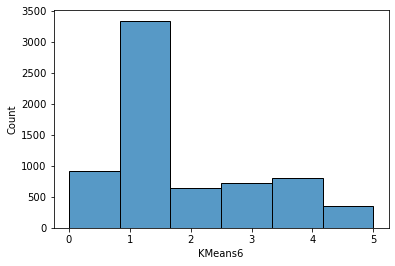

In [70]:
# How are the clusters distributed?
ax = sns.histplot(data=rs, x=c_nm, bins=k_pref);

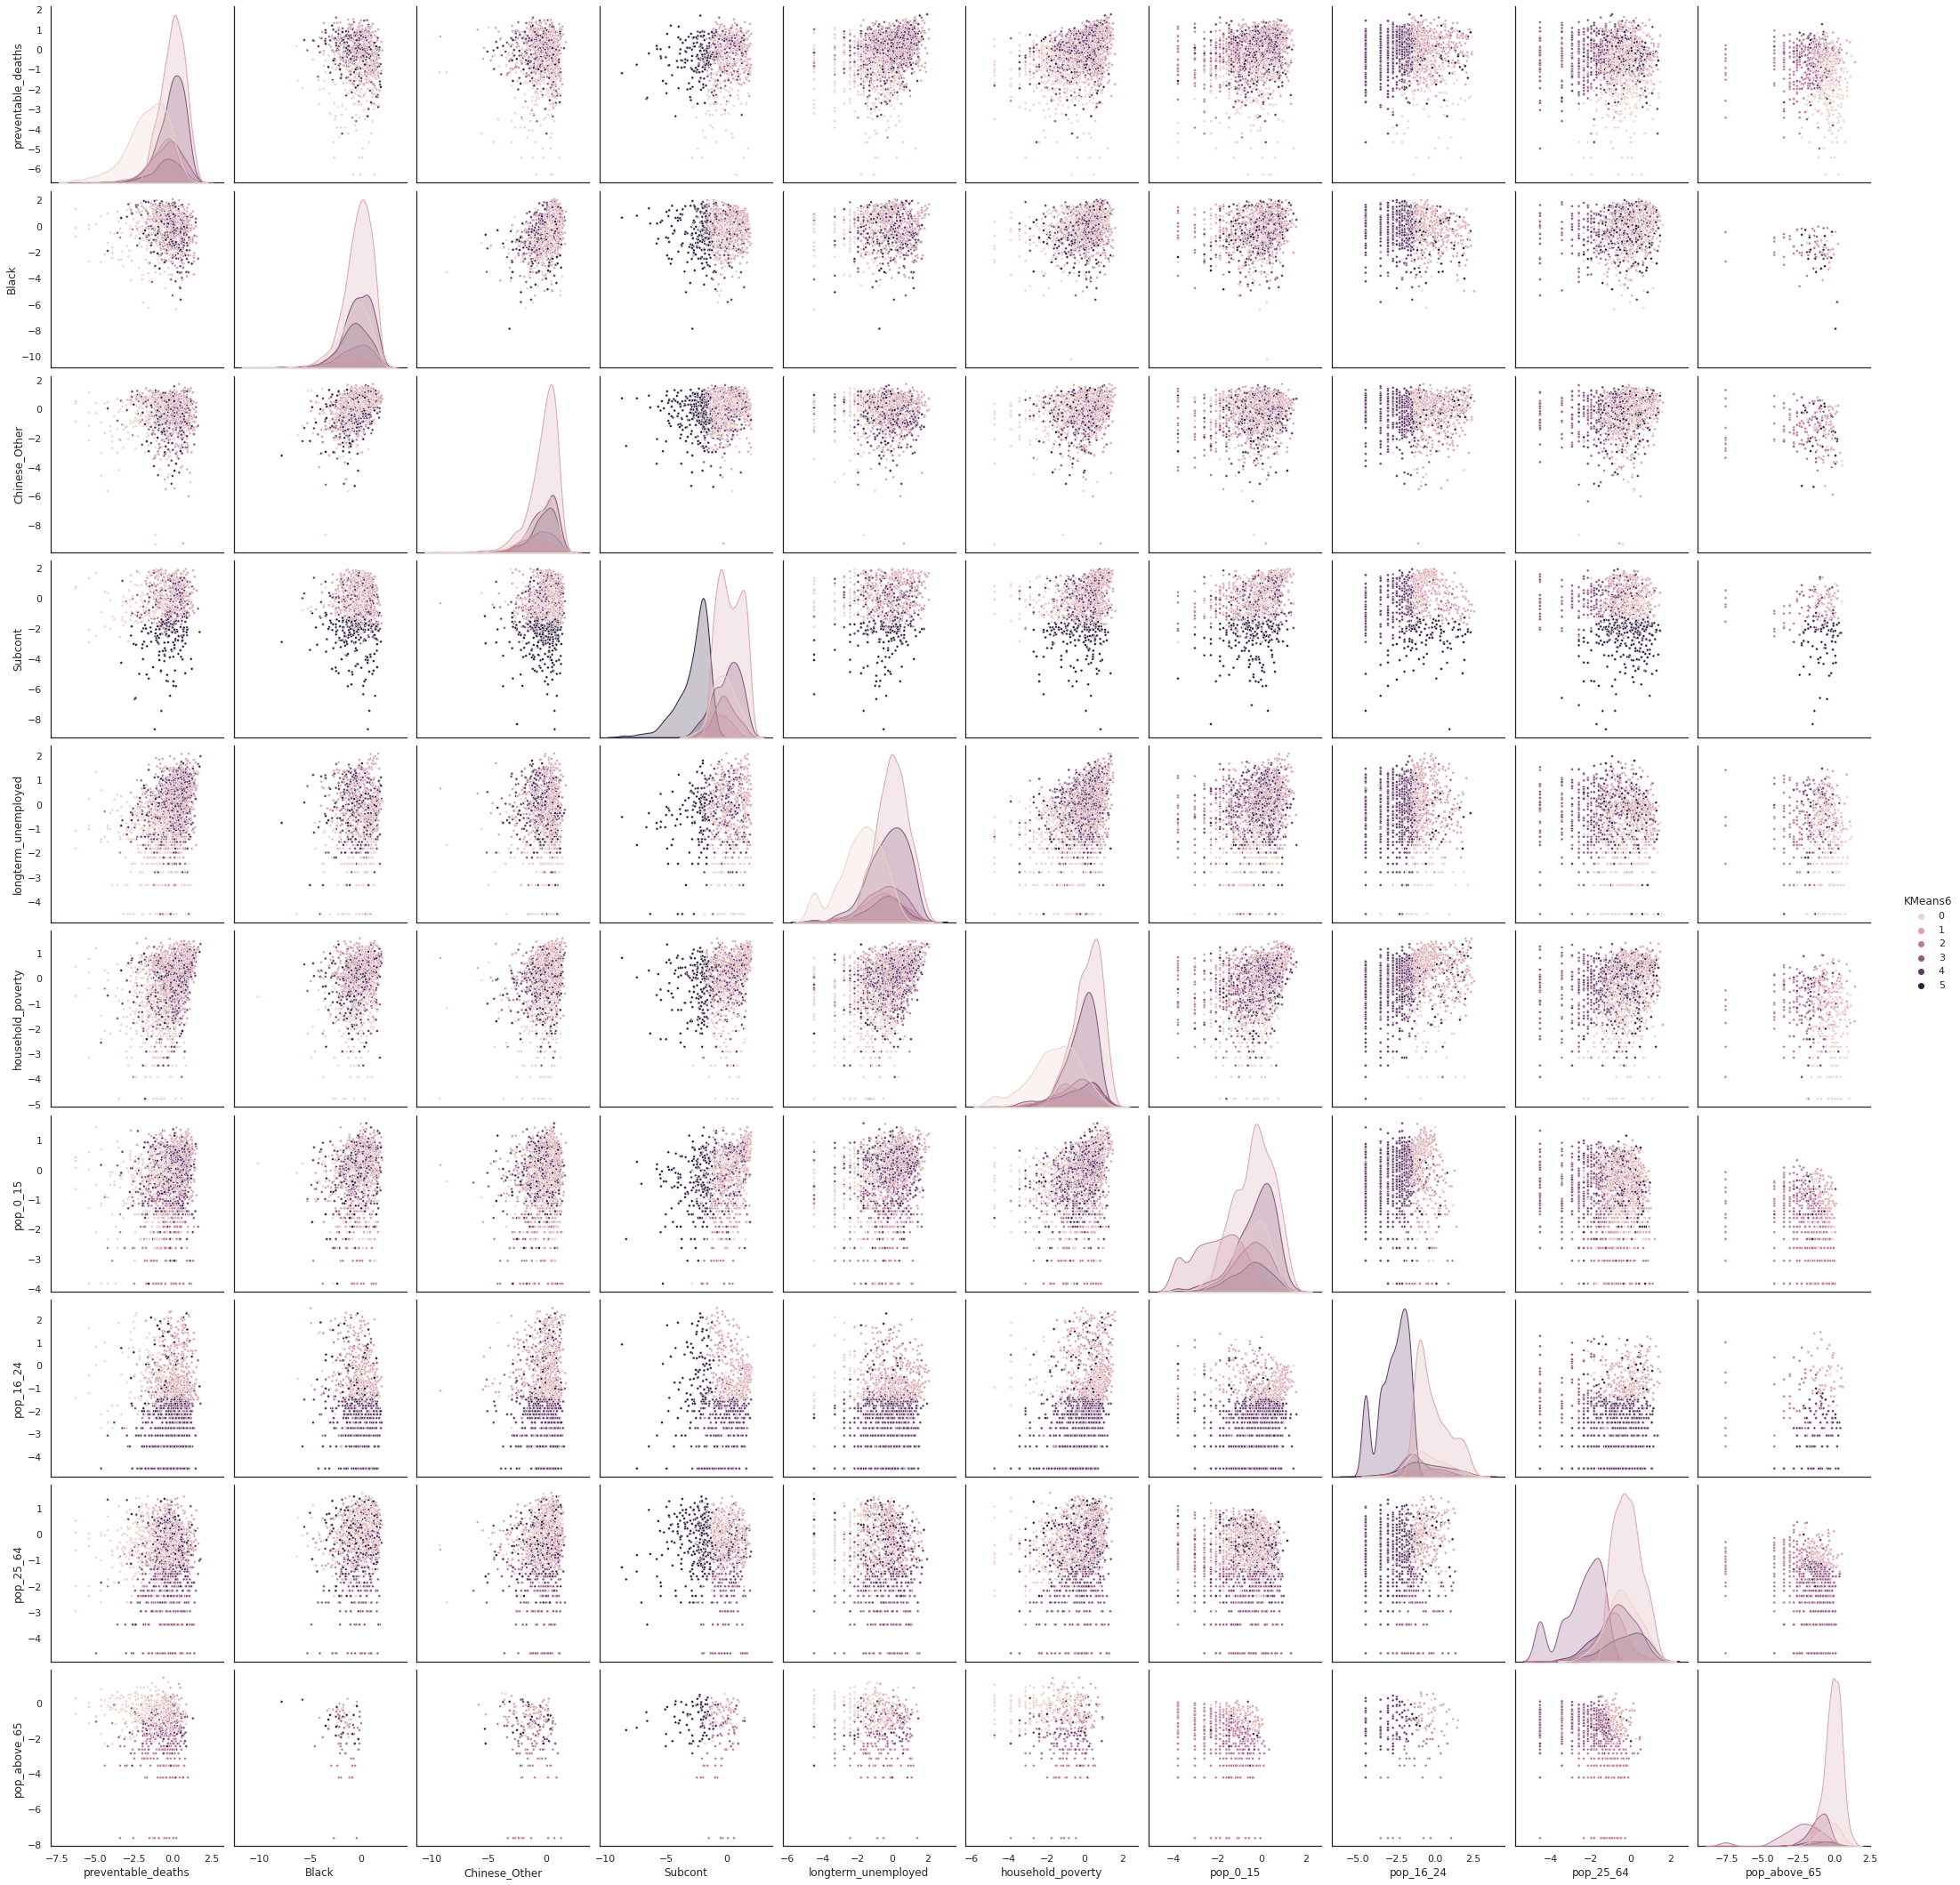

In [71]:
# There are 'only' 10 variables to plot so we'll plot them all against each other plot every variable against every
sns.set(style="white")
sns.pairplot(rs, 
             vars=gdf_vars.columns, 
             hue=c_nm, markers=".", height=3, diag_kind='kde');

And here's a map!

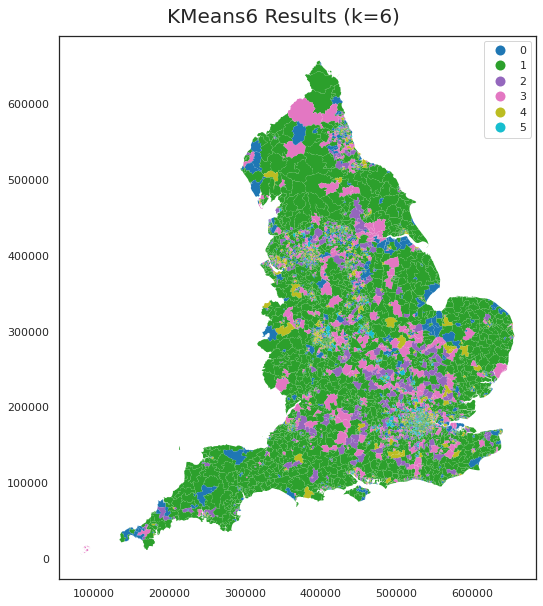

In [72]:
fig, ax = plt.subplots(figsize=(16,10))
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

#### The 'Right' Number of Clusters

There's more than one way to find the 'right' number of clusters. In Singleton's _Geocomputation_ chapter they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (2...n) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always some benefit to adding more clusters (the perfect clustering is k==n), so you don't always see a knee.

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM).

Either way, to evaluate this in a systematic way, we want to do multiple k-means clusterings for multiple values of k and then we can look at which gives the best results...

Let's try clustering across a wider range.

...................
Largest silhouette score was 0.2823 for k=11


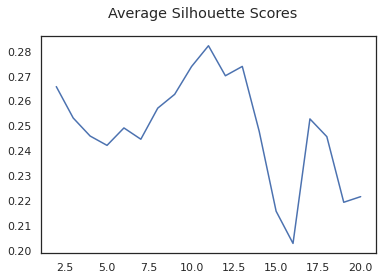

In [73]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import davies_bouldin_score, silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,21):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(gdf_vars12)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(gdf_vars12, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");

In [74]:
#https://realpython.com/k-means-clustering-python/
# SSE ELBOW METHOD 

In [75]:
# A list holds the SSE values for each k
sse1 = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42)
    kmeans.fit(gdf_vars12)
    sse1.append(kmeans.inertia_)

In [76]:
print(sse1)

[49142.76387775379, 43487.525299852285, 38854.911942025465, 35954.16449004786, 33426.06353380427, 31256.609841009325, 29201.893541161637, 27304.810598376127, 25665.765835484304, 24140.17336715797, 22872.297749408724, 22075.099618507822, 21353.181620806172, 20786.58542273263, 20406.832803914967, 20005.899213962264, 19604.381891383473, 19305.28679575382, 18936.35963991561, 18623.548730698774]


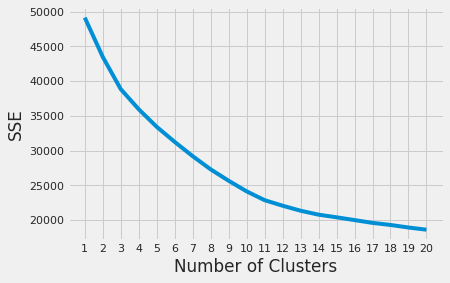

In [77]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse1)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
#plt.title('SSE Curve for PowerTransformed Clusters')

#plt.savefig('PwrTran_clusters_SSEelbow.png', bbox_inches='tight')
plt.show()

In [78]:
#SILHOUTTE COEFFICIENT 

In [79]:
silhouette_coefficients1 = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42)
    kmeans.fit(gdf_vars12)
    score = silhouette_score(gdf_vars12, kmeans.labels_)
    silhouette_coefficients1.append(score)

In [80]:
print(silhouette_coefficients1)

[0.2659021969021235, 0.25328377019865145, 0.24603711285044175, 0.24227907616385488, 0.24928684009145946, 0.2447470121425893, 0.25724212419503695, 0.2627954508417707, 0.2739805639423202, 0.2823313499557864, 0.2702610040692216, 0.27402130963833293, 0.2479192467548031, 0.21581604459428191, 0.20285948428846198, 0.2529097369144721, 0.24578145312440974, 0.21940078229104762, 0.2216631743503938]


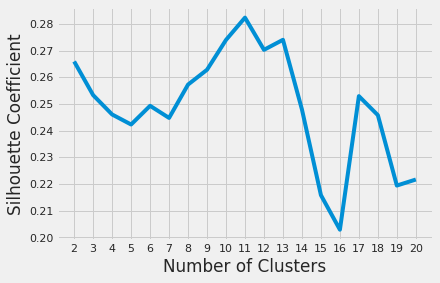

In [81]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 21), silhouette_coefficients1)
plt.xticks(range(2, 21)) 
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
#plt.title('Silhouette Coefficient Plot for\nPowerTransformed Clusters')
#plt.savefig('PwrTran_clusters_Silhouette.png', bbox_inches='tight')
plt.show()

In [82]:
# Davies-Bouldin Index

In [83]:
db_index = []

for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42)
    kmeans.fit(gdf_vars12)
    
    value = davies_bouldin_score(gdf_vars12,kmeans.labels_)
    db_index.append(value)

In [84]:
print(db_index)

[1.8868234483543291, 1.8296648114460023, 2.0156381439156754, 1.864449261534763, 1.7540313976493083, 1.6526060230624977, 1.4880977472653092, 1.4578283384794233, 1.368704214287605, 1.1990148285264615, 1.3100186990922618, 1.2831958514680417, 1.3088577450204737, 1.3423703810943908, 1.389209591496972, 1.4810947014192675, 1.5486108456183425, 1.5593852519831866, 1.5489361390101999]


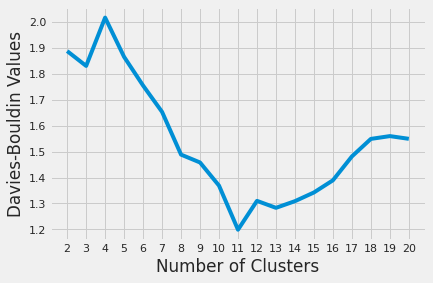

In [85]:
plt.style.use("fivethirtyeight")
plt.plot(range(2,21), db_index)
plt.xticks(range(2, 21)) 
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Values")
#plt.savefig('_clusters_Silhouette.png', bbox_inches='tight')
plt.show()

In [86]:
# 11 clusters appear to be optimal
# How we justify our selection of whatever number of clusters is the question

## Second K-Means Clustering
#### Let's see what the 11 'optimal' clusters look like

In [87]:
c_nm11   = 'KMeans11' # Clustering name
k_pref = 11 # Number of clusters

kmeans11 = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(gdf_vars12) # The process

print(kmeans11.labels_)

[ 1  3  6 ... 10  9 10]


Capture the cluster centers for our table:

In [88]:
centers11 = kmeans11.cluster_centers_
print(centers11)

[[-1.29411475e-01 -2.19193636e-02 -4.68972794e-02 -1.94137006e-02
  -8.76389827e-02 -9.30809384e-02 -1.45006236e-01 -2.20572792e-01
  -2.62149472e+00 -5.77850744e-01]
 [-1.96491528e-01 -7.73877182e-02 -3.54232232e-02 -2.91828853e+00
  -1.31728135e-01 -9.63768023e-02 -2.44798674e-01 -2.48020924e-01
  -1.82656199e-01 -1.62935540e-01]
 [-1.46746795e-01 -8.36515992e-03  4.02957873e-03 -4.52137325e-02
  -7.24517966e-02 -7.32202174e-02 -2.12340899e+00 -9.33538635e-02
  -2.91169774e-01 -4.62145858e-01]
 [-6.09255993e-02 -1.07473085e-02 -5.51858498e-02 -5.62495780e-03
  -6.25678373e-02 -1.78872992e-01 -1.75282748e-01 -2.84586199e+00
  -4.13250511e-01 -1.64779966e-01]
 [-6.41455419e-02 -2.44420686e-01 -2.85768293e+00 -1.76341776e-01
  -2.01475215e-01 -1.56013989e-01 -2.61361942e-01 -1.92607030e-01
  -2.93755076e-01 -2.14274283e-01]
 [-3.17280343e-01 -9.14112302e-02 -1.74407100e-01 -8.02549604e-02
  -1.82239832e-01 -2.07065557e-01 -7.89612009e-01 -1.30801578e-01
  -8.31779621e-01 -3.37570200e+00

In [89]:
# https://datatofish.com/numpy-array-to-pandas-dataframe/
# convert the array to a dataframe

eleven_clusters = pd.DataFrame(centers11, columns = gdf_vars.columns, index = ['Cluster 1 Center','Cluster 2 Center',
                                                                               'Cluster 3 Center', 'Cluster 4 Center', 
                                                                               'Cluster 5 Center', 'Cluster 6 Center', 
                                                                               'Cluster 7 Center','Cluster 8 Center',
                                                                               'Cluster 9 Center', 'Cluster 10 Center', 
                                                                               'Cluster 11 Center'])
print(eleven_clusters)

                   preventable_deaths  Black  Chinese_Other  Subcont  \
Cluster 1 Center                -0.13  -0.02          -0.05    -0.02   
Cluster 2 Center                -0.20  -0.08          -0.04    -2.92   
Cluster 3 Center                -0.15  -0.01           0.00    -0.05   
Cluster 4 Center                -0.06  -0.01          -0.06    -0.01   
Cluster 5 Center                -0.06  -0.24          -2.86    -0.18   
Cluster 6 Center                -0.32  -0.09          -0.17    -0.08   
Cluster 7 Center                -0.45  -0.12          -0.08    -0.06   
Cluster 8 Center                -0.32  -0.00           0.06    -0.03   
Cluster 9 Center                -0.04  -3.02          -0.46    -0.24   
Cluster 10 Center               -2.79  -0.03          -0.07    -0.09   
Cluster 11 Center                0.00   0.02           0.03     0.04   

                   longterm_unemployed  household_poverty  pop_0_15  \
Cluster 1 Center                 -0.09              -0.09     -0

In [90]:
#https://note.nkmk.me/en/python-pandas-t-transpose/#:~:text=Use%20the%20T%20attribute%20or,columns%20swapped%20(%3D%20transposed%20object).
# Need to transpose the dataframe (swap the comuns and rows) to get it into desired format

eleven_clusters = eleven_clusters.T
print(eleven_clusters)

                     Cluster 1 Center  Cluster 2 Center  Cluster 3 Center  \
preventable_deaths              -0.13             -0.20             -0.15   
Black                           -0.02             -0.08             -0.01   
Chinese_Other                   -0.05             -0.04              0.00   
Subcont                         -0.02             -2.92             -0.05   
longterm_unemployed             -0.09             -0.13             -0.07   
household_poverty               -0.09             -0.10             -0.07   
pop_0_15                        -0.15             -0.24             -2.12   
pop_16_24                       -0.22             -0.25             -0.09   
pop_25_64                       -2.62             -0.18             -0.29   
pop_above_65                    -0.58             -0.16             -0.46   

                     Cluster 4 Center  Cluster 5 Center  Cluster 6 Center  \
preventable_deaths              -0.06             -0.06             -0.32  

Now capture the labels (i.e. clusters) and write them to a data series that we store on the result set df (`rs`):

In [91]:
# Add it to the data frame
rs[c_nm11] = pd.Series(kmeans11.labels_, index=gdf_vars12.index)

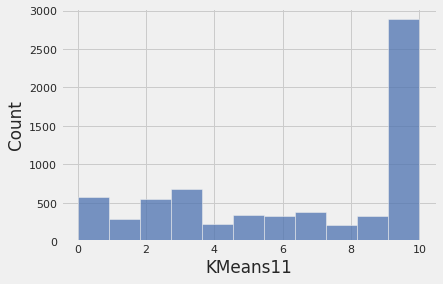

In [92]:
# How are the clusters distributed?
ax = sns.histplot(data=rs, x=c_nm11, bins=k_pref);

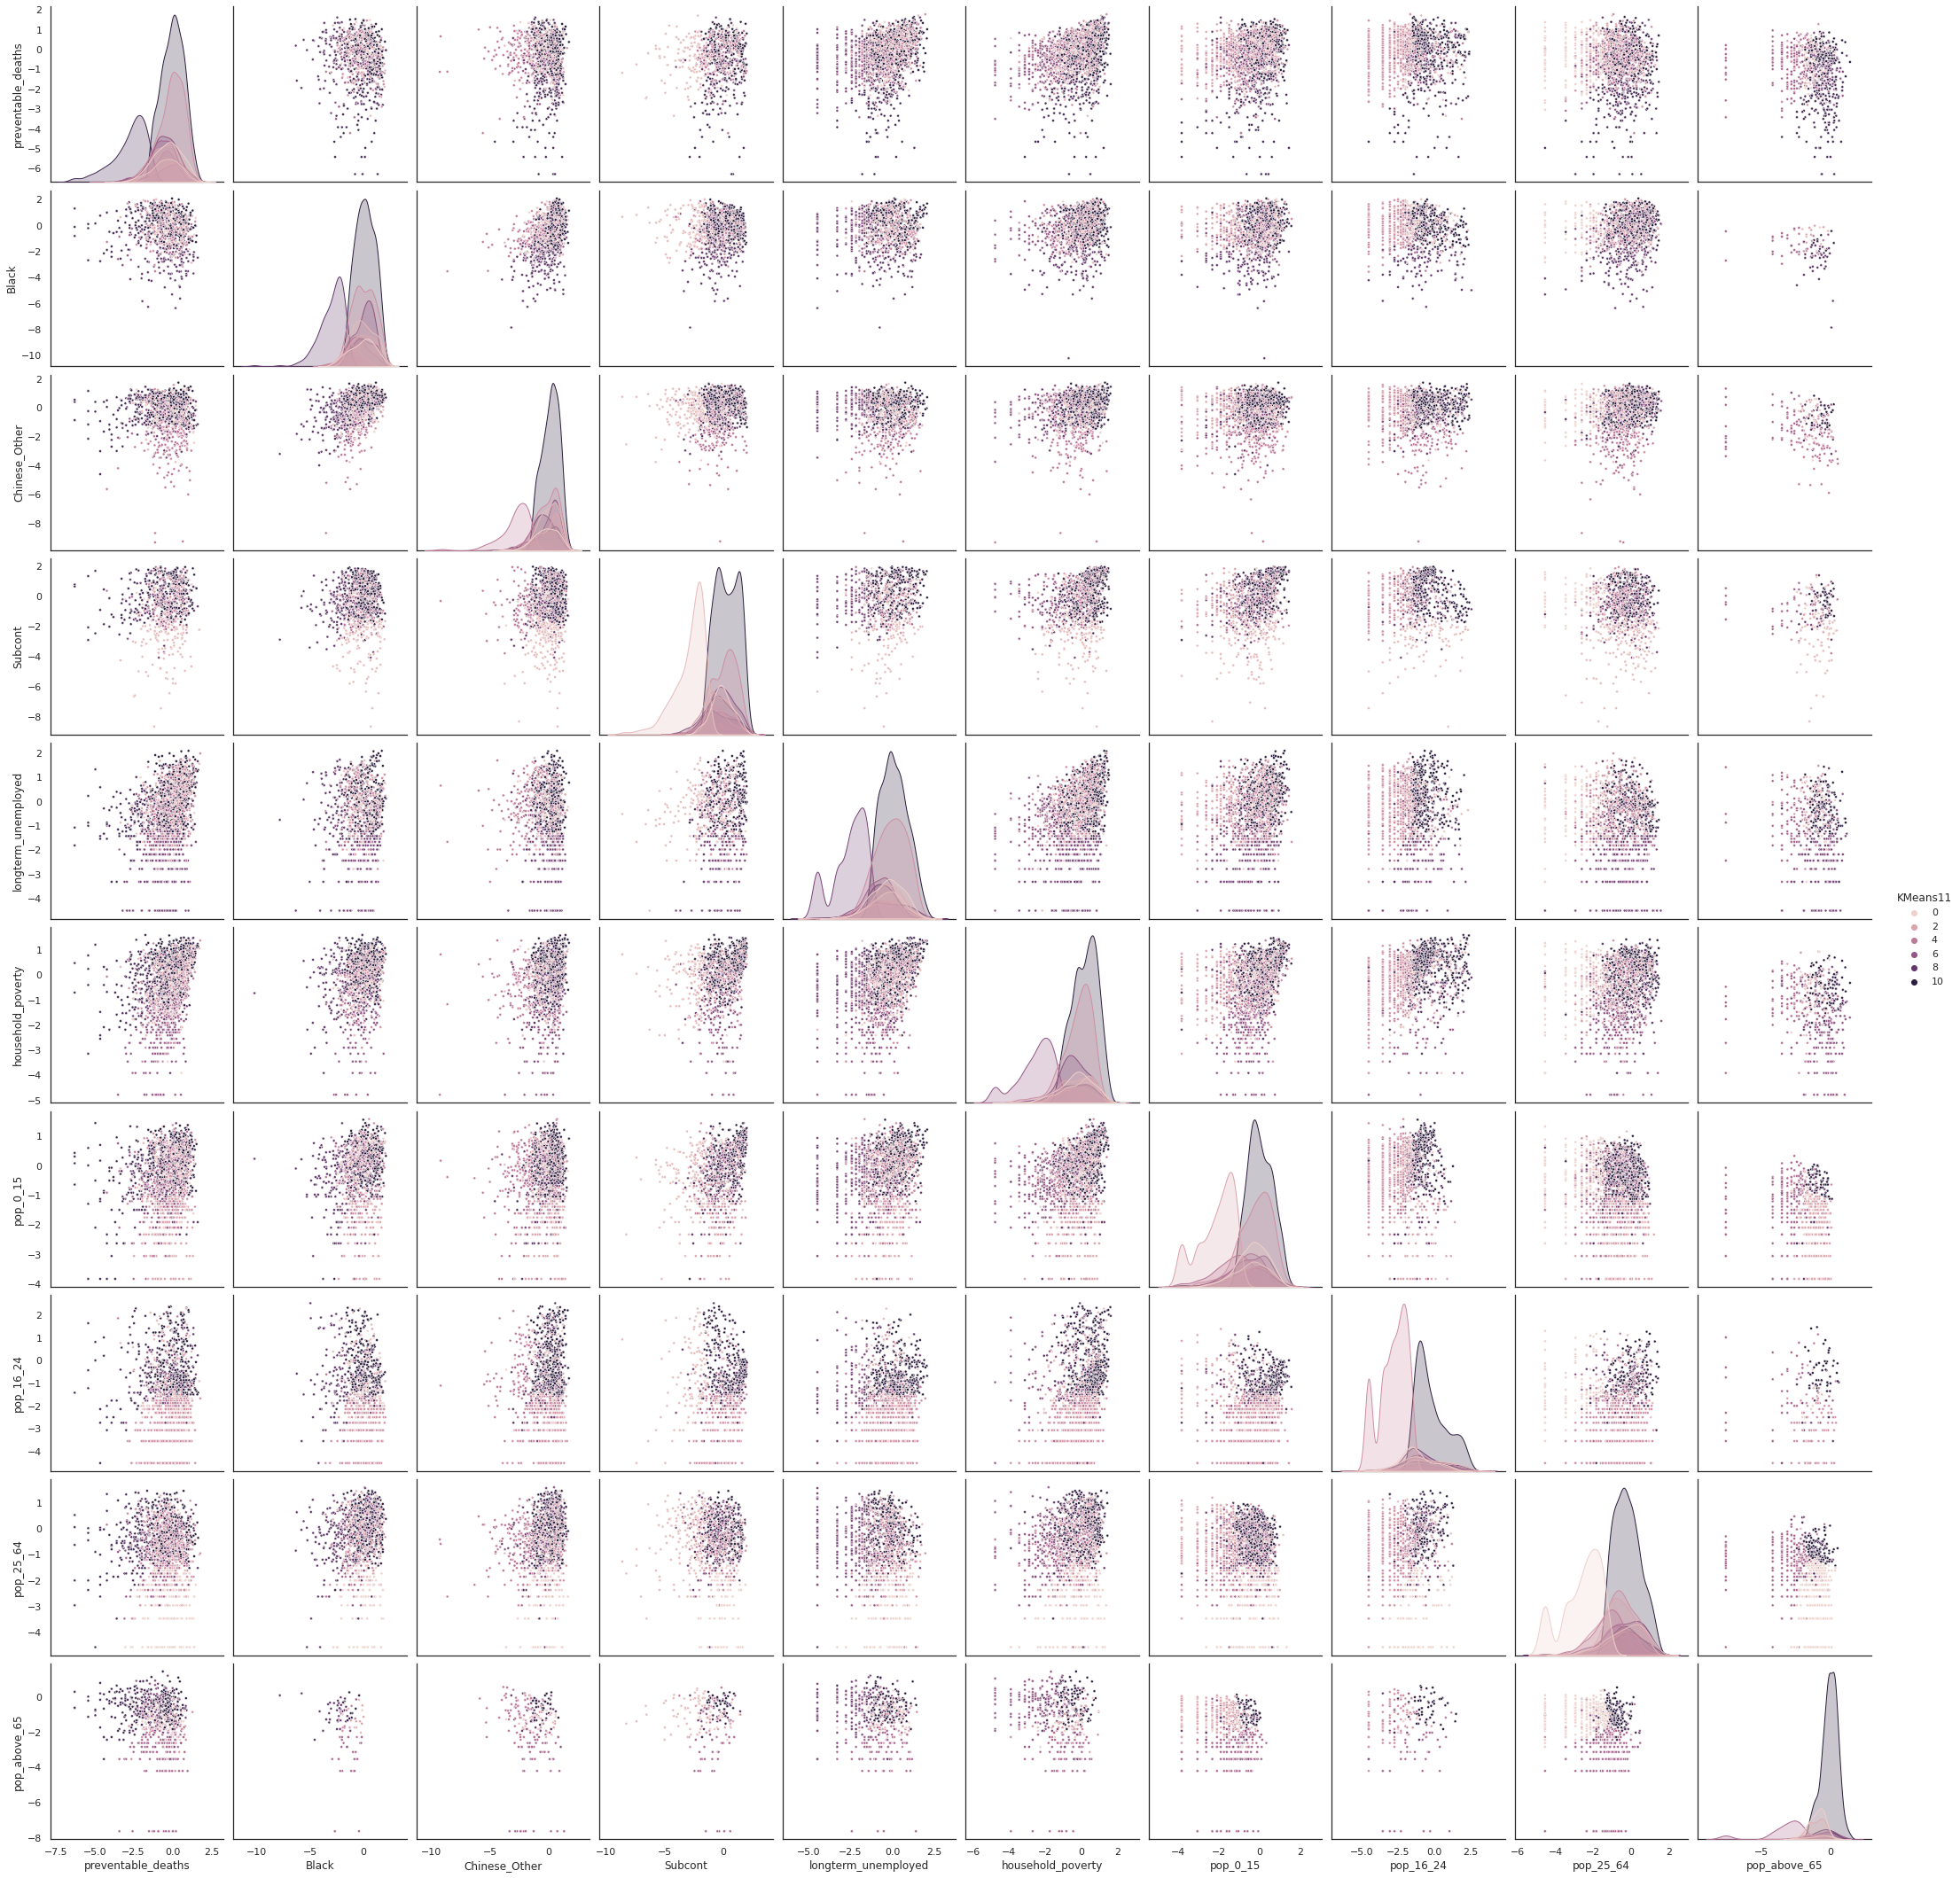

In [93]:
# There are 'only' 10 variables to plot so we'll plot them all against each other plot every variable against every
sns.set(style="white")
sns.pairplot(rs, 
             vars=gdf_vars.columns, 
             hue=c_nm11, markers=".", height=3, diag_kind='kde');

And here's a map!

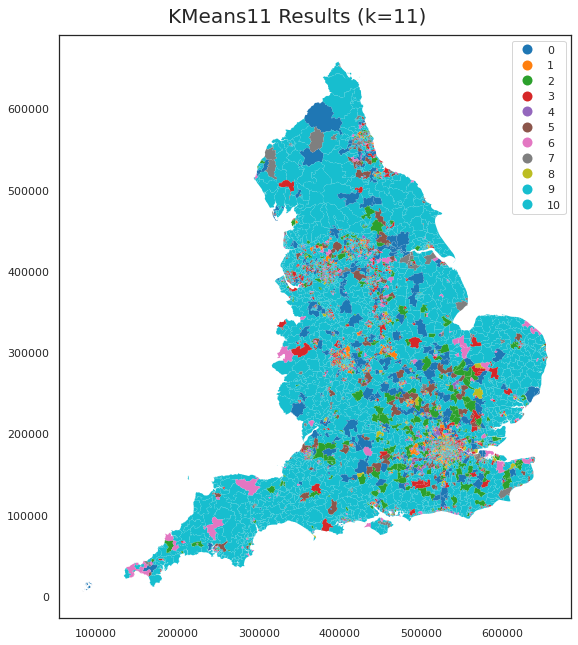

In [94]:
fig, ax = plt.subplots(figsize=(16,10))
fig.suptitle(f"{c_nm11} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm11, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

## Third K-Means Clustering
#### Let's see what  8 clusters look like

In [95]:
c_nm8   = 'KMeans8' # Clustering name
k_pref = 8 # Number of clusters

kmeans8 = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(gdf_vars12) # The process

print(kmeans8.labels_)

[2 5 3 ... 6 7 6]


Capture the cluster centers for our table:

In [96]:
centers8 = kmeans8.cluster_centers_
print(centers8)

[[-0.13890029 -0.09645673 -0.11678441 -0.02486797 -0.10918095 -0.13663993
  -0.15532892 -0.2135168  -2.56792209 -0.54897923]
 [-0.15004193 -0.14954884 -0.12670217 -0.05730691 -0.11499853 -0.10432966
  -2.09192702 -0.11053897 -0.27265961 -0.423025  ]
 [-0.18370967 -0.39999815 -0.2578207  -2.78558372 -0.17050047 -0.15882294
  -0.25123474 -0.20882146 -0.19397478 -0.18267871]
 [-0.30150742 -0.25878119 -0.1803764  -0.03899911 -1.66508981 -1.37298735
  -0.20857177 -0.1446664  -0.24140692 -0.12957152]
 [-0.31088671 -0.11820201 -0.21123469 -0.07774818 -0.22609239 -0.23305662
  -0.79196253 -0.12518107 -0.79960052 -3.29166449]
 [-0.05130952 -0.11951909 -0.13987081 -0.01264231 -0.1021872  -0.17119751
  -0.1704512  -2.77711618 -0.39255389 -0.15802755]
 [ 0.00785666 -0.04629447 -0.06462601  0.04133807  0.01494551  0.03395157
   0.00764325 -0.02513143 -0.05102807 -0.04402295]
 [-2.71132303 -0.13247243 -0.14214923 -0.08428482 -0.25635871 -0.28125567
  -0.20731729 -0.15133075 -0.22611675 -0.24338991]]

Now capture the labels (i.e. clusters) and write them to a data series that we store on the result set df (`rs`):

In [97]:
# Add it to the data frame
rs[c_nm8] = pd.Series(kmeans8.labels_, index=gdf_vars12.index)

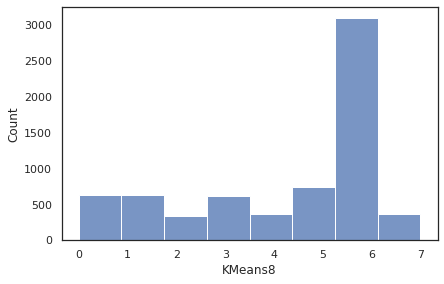

In [98]:
# How are the clusters distributed?
ax = sns.histplot(data=rs, x=c_nm8, bins=k_pref);

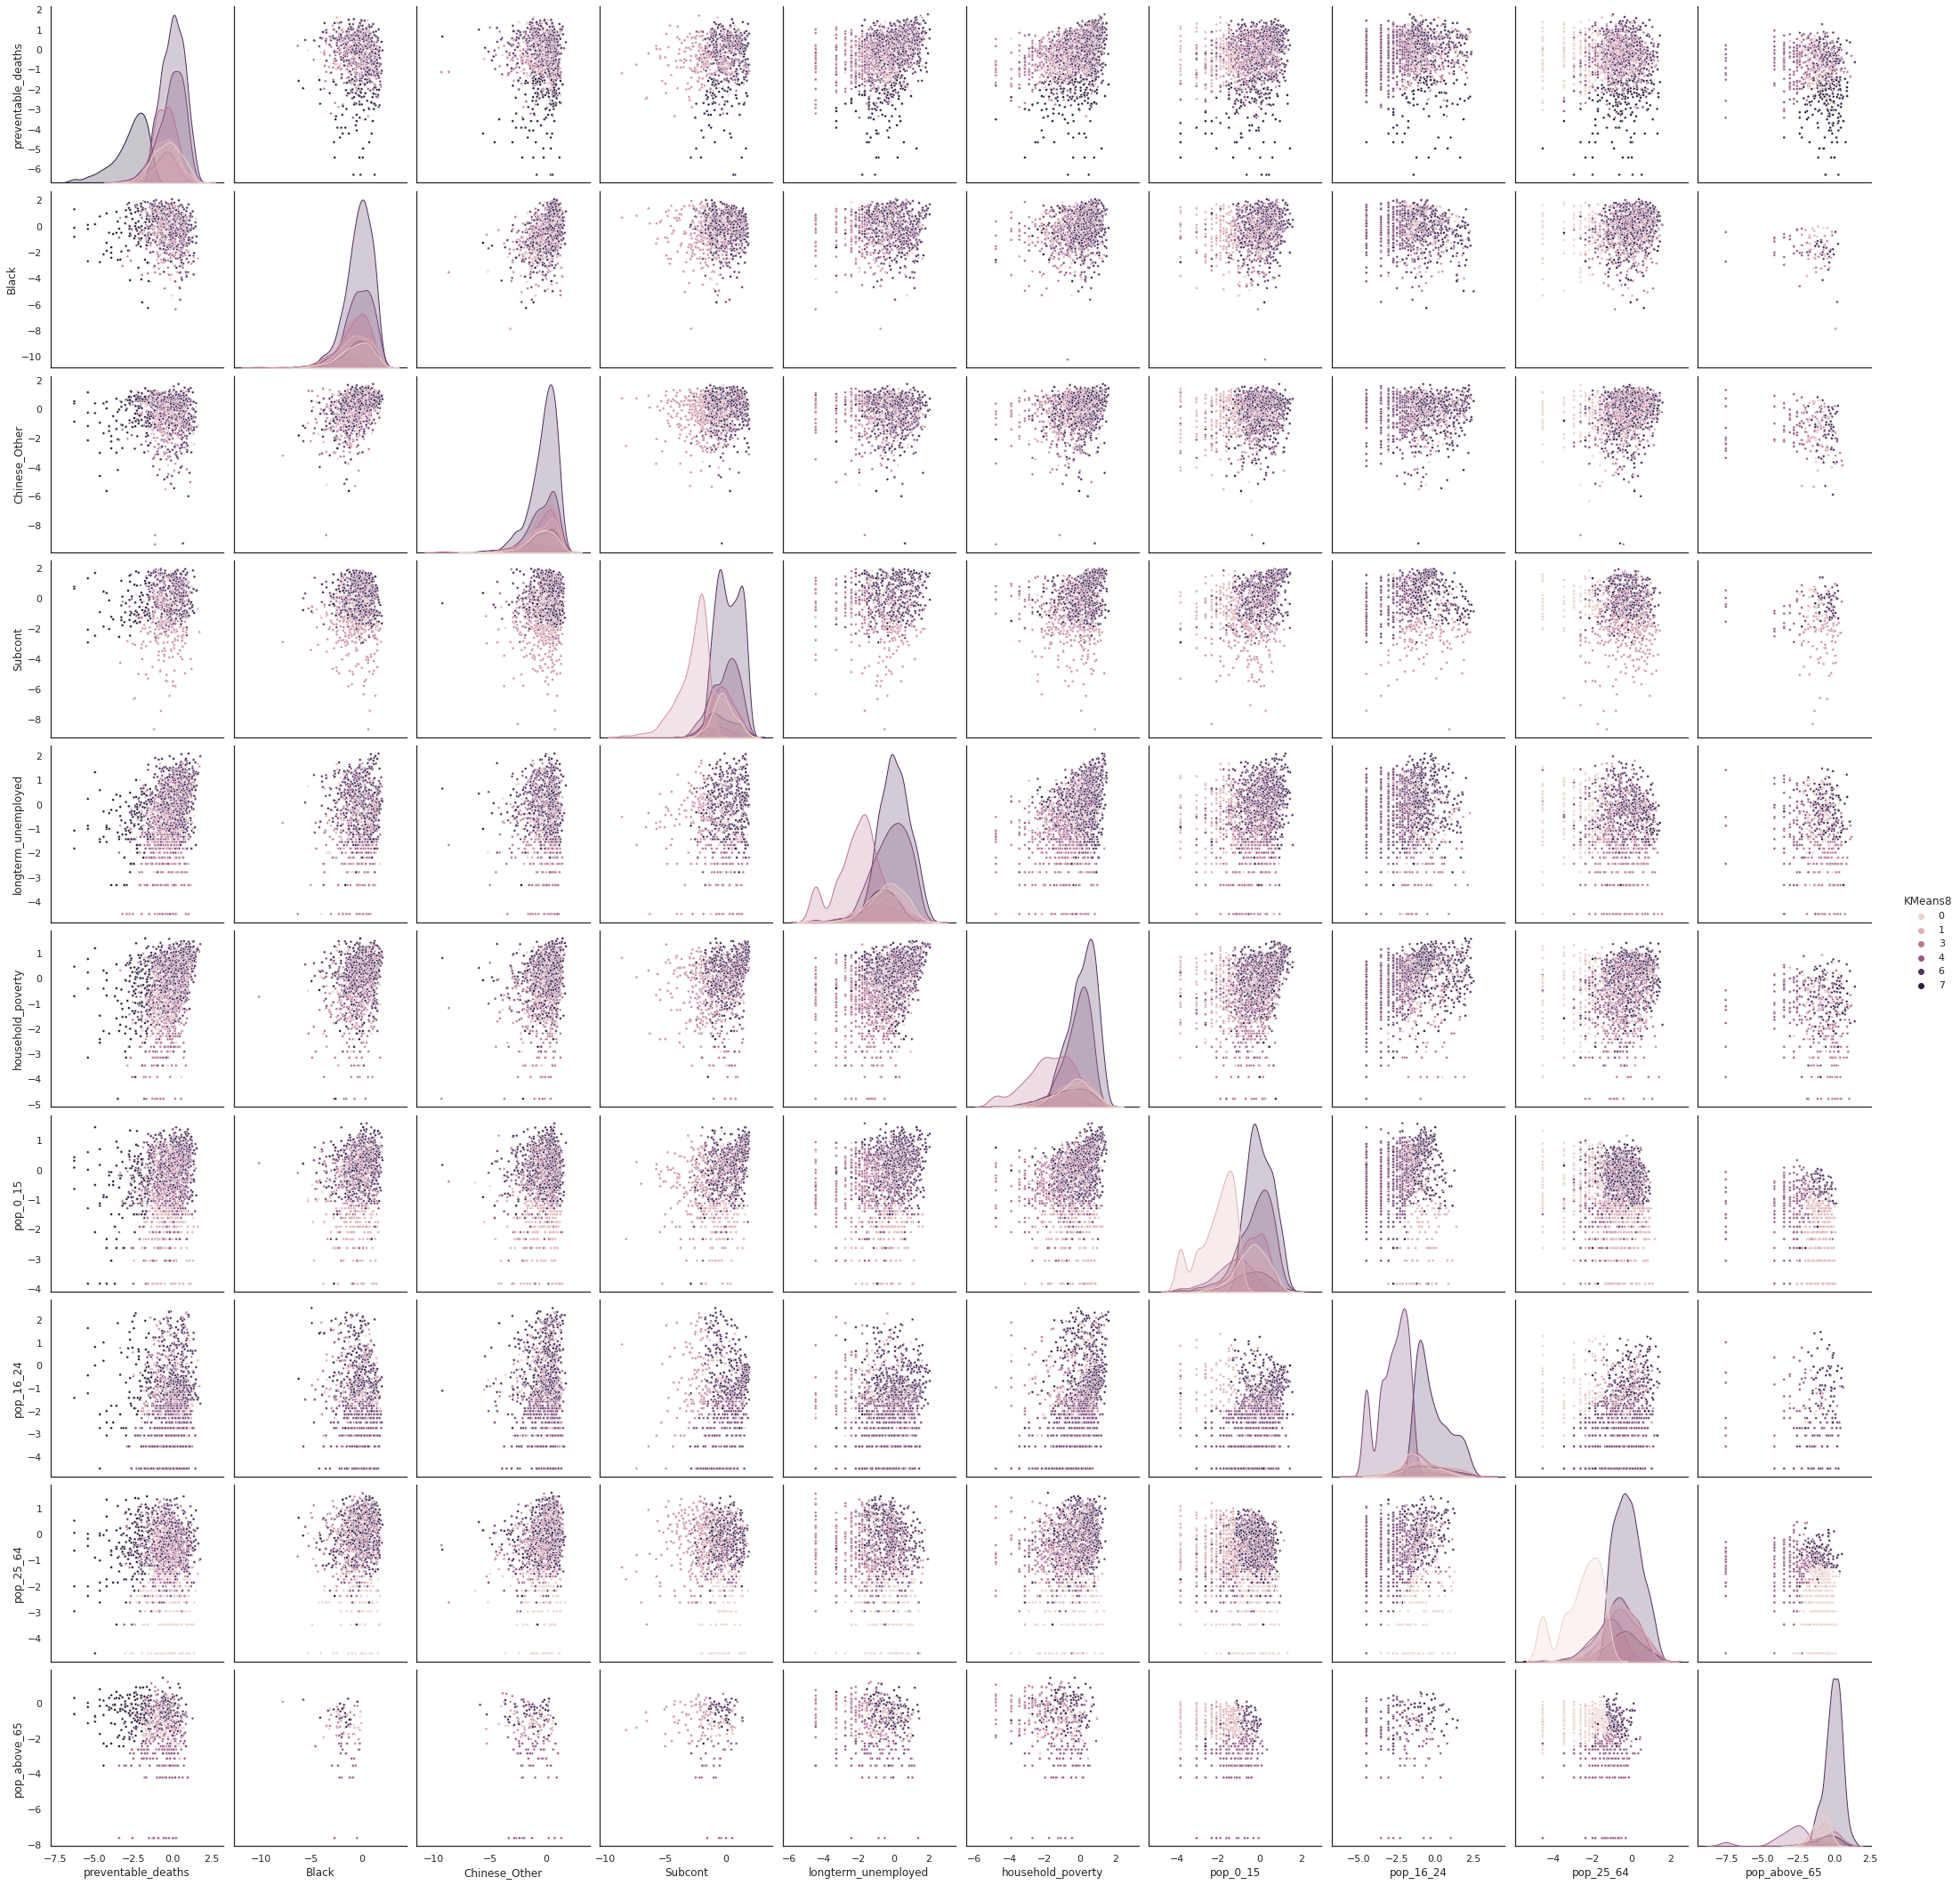

In [99]:
# There are 'only' 11 variables to plot so we'll plot them all against each other plot every variable against every
sns.set(style="white")
sns.pairplot(rs, 
             vars=gdf_vars.columns, 
             hue=c_nm8, markers=".", height=3, diag_kind='kde');

And here's a map!

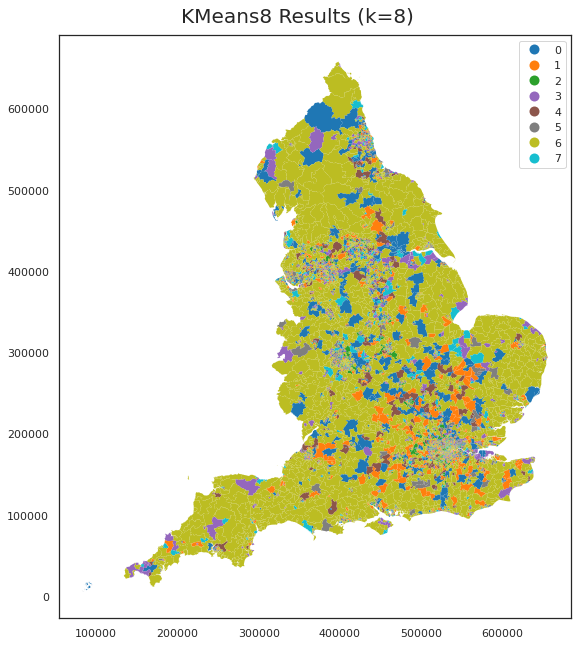

In [100]:
fig, ax = plt.subplots(figsize=(16,10))
fig.suptitle(f"{c_nm8} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm8, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);